<a href="https://colab.research.google.com/github/ArthurLepsien/PINNs/blob/main/Spraydrying_Force.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [414]:
#!pip install -Uqq ipdb
import ipdb
%pdb off

Automatic pdb calling has been turned OFF


In [415]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [416]:
# save gif function
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# class to generate a fully connected neural network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fci = nn.Sequential(*[
                        nn.Flatten()])
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        #x = self.fci(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

  # plotting function 
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.semilogx(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.semilogx(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(0.1, 100.05)
    plt.ylim(min(min(y),min(y_data.detach().numpy()))-2, max(max(y),max(y_data.detach().numpy()))+2)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    #plt.axis("off")

In [417]:
def plot_experimental_results(run):
    experiments = np.array([[10,170,5],[10,170,10],[18,135,10],[10,135,5],
                            [18,170,5],[10,170,15],[1,170,15],[10,100,15],
                            [18,170,10],[1,100,10],[1,135,5],[18,100,15],
                            [1,170,5],[18,135,15],[18,100,5],[18,170,15],
                            [1,170,10],[1,100,5],[10,100,10],[18,100,10],
                            [18,135,5],[10,135,15],[1,135,15],[1,100,15],
                            [10,135,10],[1,135,10],[10,100,5]])
    T_experiment = experiments[run-1,1] # temperature
    c_experiment = experiments[run-1,0]  # concentration
    p_experiment = experiments[run-1,2]   # pump rate
    print('Input Parameters:',T_experiment, c_experiment,p_experiment)
    data = np.genfromtxt('drive/MyDrive/Colab Notebooks/Spraydrying_Force/N'+str(run)+'_dist.dat')
    x=data[0:,0]
    v=data[0:,1]
    # Normalize Data
    V0 = np.trapz(v,x)
    y = v/V0
    # cut to first zero in measurements
    n = np.where(y==0)[0][0] 
    Phi = - np.log(y[0:n])
    x_restricted = x[0:n]
    # initlize experimental force and estimated potential vector
    f_experiment = np.zeros([1,n-1])
    Phi_estimated = np.zeros([n-2,1])
    # forces \dot x = - f(x) " F = m * a style "
    dlx1 = np.log10(x[1])-np.log10(x[0])
    f_experiment[0,0] = (Phi[1]-Phi[0])/dlx1
    # first order finite difference differentiatiation to get force
    for i in range(1,n-1):
        dlxi = np.log10(x[i+1])-np.log10(x[i]) # log10 difference, because semilogy scale
        f_experiment[0,i] = (Phi[i+1]-Phi[i])/dlxi
    xrr = x_restricted[0:n-1]
    input = torch.zeros([len(xrr),4])
    input[:,0] = torch.from_numpy(xrr)
    input[:,1] = T_experiment
    input[:,2] = c_experiment
    input[:,3] = p_experiment
    #print(input)
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    ax1.semilogx(x,y,label='Distribution')
    ax2.semilogx(x_restricted, Phi, label='Potential')
    ax3.semilogx(xrr, np.transpose(f_experiment), label='Force')
    fig.tight_layout()
    plt.setp([ax1,ax2,ax3], xlim=ax3.get_xlim())
    ax1.set_title('Measurement data')
    return (x,y, xrr ,f_experiment,Phi, input)

Input Parameters: 170 10 5
Input Parameters: 170 10 15


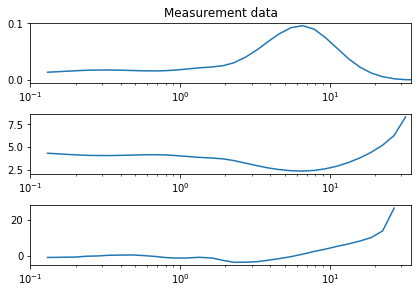

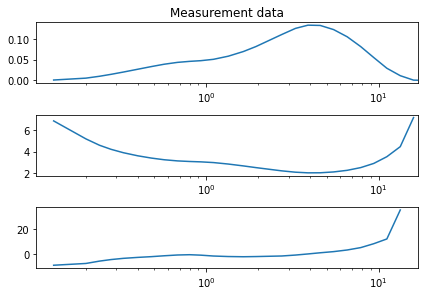

In [418]:
# get training data from experiment 1 and 2 to predict experiment 6
[x1,y1, xrr1,f_experiment1,Phi1, input1] = plot_experimental_results(1)
[x2,y2, xrr2,f_experiment2,Phi2, input2] = plot_experimental_results(6)
input = torch.cat((input1, input2), 0)
force = np.append(f_experiment1, f_experiment2)
#input = input1
#force = f_experiment1

In [419]:
# train neural network to fit data
plotting = False
torch.manual_seed(123)
model = FCN(4,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
max_iter = 3000
y_data = torch.from_numpy(np.transpose(force))
y_data =  y_data.unsqueeze(1)
print(input.shape, y_data.shape)
for i in range(max_iter):
    optimizer.zero_grad()
    yh = model(input)
    loss = nn.SmoothL1Loss() #torch.mean((yh-y_data)**2)# use mean squared error
    output = loss(yh, y_data)
    output.backward()
    optimizer.step()
    if plotting:
    # plot the result as training progresses
        if (i+1) % 100 == 0: 
            
            yh = model(input).detach()
            
            plot_result(xrr1,np.transpose(force),input[:,0],y_data,yh)
            
            file = "drive/MyDrive/Colab Notebooks/Spraydrying_Force/plots/nn_%.8i.png"%(i+1)
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            files.append(file)
        
            if (i+1) % 1000 == 0: plt.show()
            else: plt.close("all")
if plotting:
    save_gif_PIL("drive/MyDrive/Colab Notebooks/Spraydrying_Force/plots/nn.gif", files, fps=20, loop=0)

torch.Size([55, 4]) torch.Size([55, 1])


Input Parameters: 170 10 10


(-11.068262100219727, 45.80827079942994)

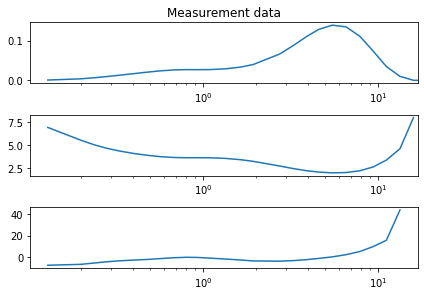

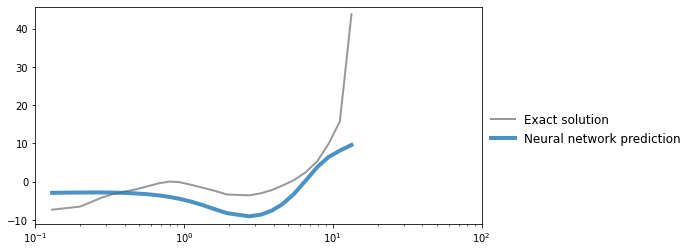

In [420]:
# predict new experiment
#plot_experimental_results(1)
[x,_, xrr,f_experiment,_, input_pred] = plot_experimental_results(2)
y_pred = model(input_pred).detach()
plt.figure(figsize=(8,4))
plt.semilogx(xrr,np.transpose(f_experiment), color="grey", linewidth=2, alpha=0.8, label="Exact solution")
plt.semilogx(xrr,y_pred, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.xlim(0.1, 100.05)
plt.ylim(min(min(np.transpose(f_experiment)),min(y_pred.detach().numpy()))-2, max(max(np.transpose(f_experiment)),max(y_pred.detach().numpy()))+2)